<h1 style="color: 	#365F93;"><strong>Chess winner prediction</strong></h1>

<h2 style="color: 	#80B1D3;"><strong>Librerias</strong></h2>

In [1]:
import pandas as pd
import sys
import os
sys.path.append(os.path.abspath('../src'))
from data_processing import load_chess_data, calculate_total_ply, extract_time_controls, normalize_features
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

#Cargamos el data set y vemos su forma.
df_chess = load_chess_data("../data/raw/games.csv")

Dataset cargado exitosamente desde: ../data/raw/games.csv
Forma del dataset: (20058, 16)
         id  rated    created_at  last_move_at  turns victory_status winner  \
0  TZJHLljE  False  1.504210e+12  1.504210e+12     13      outoftime  white   
1  l1NXvwaE   True  1.504130e+12  1.504130e+12     16         resign  black   
2  mIICvQHh   True  1.504130e+12  1.504130e+12     61           mate  white   
3  kWKvrqYL   True  1.504110e+12  1.504110e+12     61           mate  white   
4  9tXo1AUZ   True  1.504030e+12  1.504030e+12     95           mate  white   

  increment_code       white_id  white_rating      black_id  black_rating  \
0           15+2       bourgris          1500          a-00          1191   
1           5+10           a-00          1322     skinnerua          1261   
2           5+10         ischia          1496          a-00          1500   
3           20+0  daniamurashov          1439  adivanov2009          1454   
4           30+3      nik221107          1523  adiv

<h2 style="color: 	#80B1D3;"><strong>Limpieza de datos</strong></h2>

In [2]:
#Hay que cambiar las dos porque son datos temporales y salen como float.
df_chess['created_at'] = pd.to_datetime(df_chess['created_at'], unit='ms', errors='coerce')
df_chess['last_move_at'] = pd.to_datetime(df_chess['last_move_at'], unit='ms', errors='coerce')

In [3]:
# Despues de una exploración de los datos vemos que hay datos que no tienen sentido como:
# Nos quedamos con partidas con al menos dos turnos, suele ser muy raro una rendicion instantanea, no nos sirve para el aprendizaje.
df_chess = df_chess[df_chess['turns'] >= 2]
# Hacemos una columna nueva que cuenta los datos separados por espacios, para sustituir otra columna que nos da muchos problemas.
df_chess['total_ply_from_moves'] = calculate_total_ply(df_chess['moves'])
#Antes de eliminar las columnas que no necesito voy a ver y eliminar duplicados.
df_chess.drop_duplicates(inplace=True)
# Lista de columnas a eliminar, son columnas con demasiados datos categóricos distintos, pueden darle problemas para apender a la maquina.
columns_to_drop = ['opening_eco', 'opening_name', 'opening_ply', 'id', 'white_id', 'black_id', 'moves', 'created_at', 'last_move_at']
# Eliminar las columnas
df_chess.drop(columns=columns_to_drop, inplace=True)

<h2 style="color: 	#80B1D3;"><strong>Feature engineering</strong></h2>

In [4]:
# Vamos a crear una columna nueva muy importante:
# La diferencia de nivel de los dos jugadores.
df_chess['rating_difference'] = df_chess['white_rating'] - df_chess['black_rating']
# Descomponemos una de las columnas categóricas con demasiados datos distintos a varias
# cloumnas numericas: 'initial_time_minutes' y 'increment_seconds'.
df_chess = extract_time_controls(df_chess)

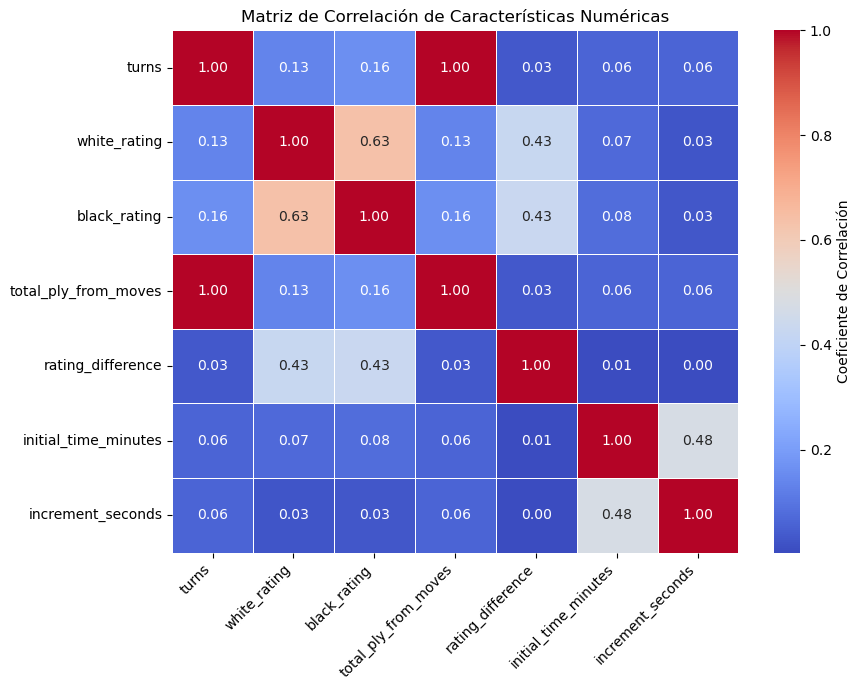

In [5]:
#Ahora que tenemos las columnas que necesitamos limpias, vamos a ver si las necesitamos todas:
#Vamso a hacer un heatmap para ver su correlacion:
numeric_cols = [
    'turns',
    'white_rating',
    'black_rating',
    'total_ply_from_moves',
    'rating_difference',
    'initial_time_minutes',
    'increment_seconds'
]

corr = np.abs(df_chess[numeric_cols].corr())

plt.figure(figsize=(9, 7)) 
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar_kws={'label': 'Coeficiente de Correlación'})
plt.title('Matriz de Correlación de Características Numéricas')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Vemos que turns y total_ply_from_moves tienen una correlación perfecta, pero la segunda que he creado, total_ply_from_moves es una medida que representa cada medio movimientoy la utilice para confirmar que los datos estaban bien sacando la infromación del conjunto de movimientos, que es la fuente completa de la partida.
total_ply_from_moves es una característica mejor para la duración de la partida.

In [6]:
df_chess.drop(columns=['turns'], inplace=True)

In [7]:
# Pasemos a codificar las variables categóricas:
df_chess = pd.get_dummies(df_chess, columns=['victory_status', 'rated'], drop_first=True)

In [9]:
# Podemos ya definir nuestro target.
features = df_chess.drop(columns='winner')
target = df_chess['winner']
# Después codificamos el target.
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(target)
# Dividimos los datos.
x_train, x_test, y_train, y_test = train_test_split(features, y_encoded, test_size=0.20, random_state=0)
# Normalizamos las características numéricas para asegurar que todas las variables tengan una escala comparable
x_train_norm, x_test_norm, scaler_fitted = normalize_features(x_train, x_test, normalizer=MinMaxScaler())